Mercari Interactive EDA + Topic Modeling

https://www.kaggle.com/thykhuely/mercari-interactive-eda-topic-modelling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
#教師データと検証データのインポート
#データサイズが大きいので、データ型を事前に指定した。
dtype = {'train_id':'int32','name':'object','item_condition_id':'int8','category_name':'object','brand_name':'object',
         'price':'float32','shipping':'int8','item_description':'object'}
#パソコンの能力が低すぎるので1万データでお勉強しまそ
train = pd.read_csv('/home/kyohei/.kaggle/competitions/mercari-price-suggestion-challenge/train.tsv',sep='\t',dtype=dtype,nrows=10000)
test = pd.read_csv('/home/kyohei/.kaggle/competitions/mercari-price-suggestion-challenge/test.tsv',sep='\t',dtype=dtype,nrows=10000)

In [3]:
print(train.shape)
print(test.shape)

(10000, 8)
(10000, 7)


In [4]:
train.head()

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        NaN   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description  
0         1                                 No description yet  
1         0  This keyboard is in great condition and works ...  
2         1  Adorable top with a hint of lace and a key hol...  
3         1  New with tags. Leather horses. Retail for [rm]...  
4         0          Complete with certificate of authenticity

In [5]:
#分布は0付近に偏ります
train.price.describe()

count    10000.000000
mean        26.429899
std         39.385696
min          0.000000
25%         10.000000
50%         16.000000
75%         29.000000
max       1506.000000
Name: price, dtype: float64

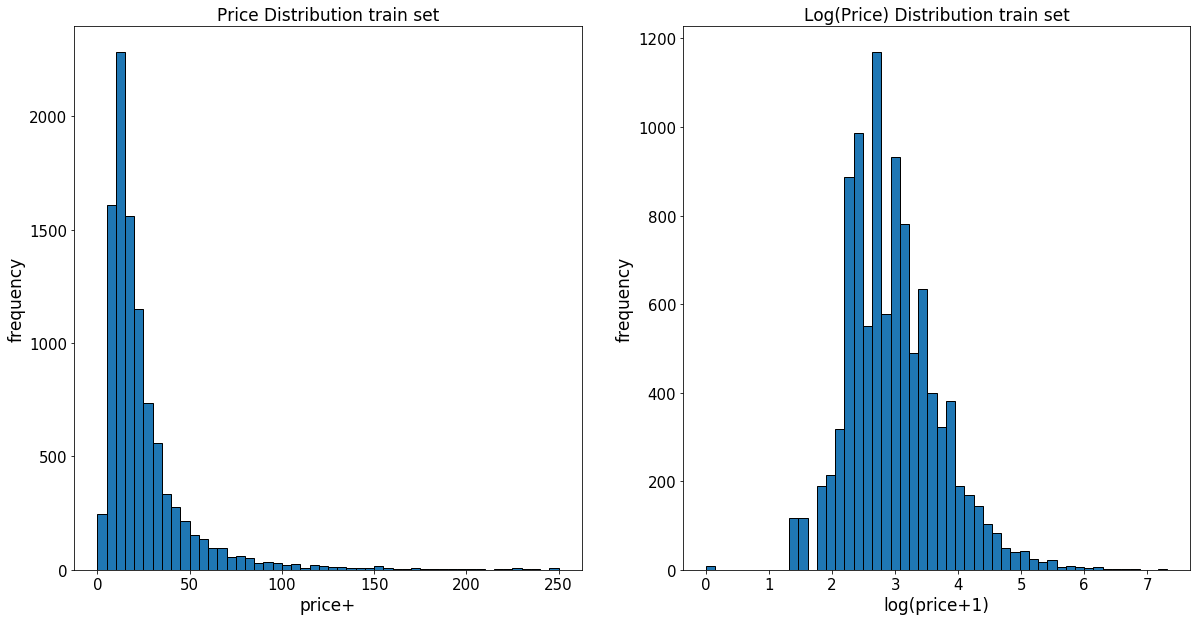

In [6]:
fig,axes = plt.subplots(1,2,figsize=(20,10))
train.price.plot(kind='hist',bins=50,edgecolor='black',range=[0,250],ax=axes[0])
axes[0].set_xlabel('price+',fontsize=17)
axes[0].set_ylabel('frequency',fontsize=17)
axes[0].tick_params(labelsize=15)
axes[0].set_title('Price Distribution train set',fontsize=17)

np.log(train.price+1).plot(kind='hist',bins=50,edgecolor='black',ax=axes[1])
axes[1].set_xlabel('log(price+1)',fontsize=17)
axes[1].set_ylabel('frequency',fontsize=17)
axes[1].tick_params(labelsize=15)
axes[1].set_title('Log(Price) Distribution train set',fontsize=17)
plt.show()

In [7]:
train.shipping.value_counts() / len(train)

0    0.5461
1    0.4539
Name: shipping, dtype: float64

商品の配送料の半分以上が売り手によって負担されている。

In [8]:
prc_shipByseller = train.loc[train.shipping==1,'price']
prc_shipByBuyer = train.loc[train.shipping==0,'price']

商品の配送料を売り手が負担するときのほうが、成約金額が安い？

In [9]:
print('by seller:{0} \n by buyer:{1}'.format(prc_shipByseller.mean(),prc_shipByBuyer.mean()))

by seller:22.1720638275 
 by buyer:29.968870163


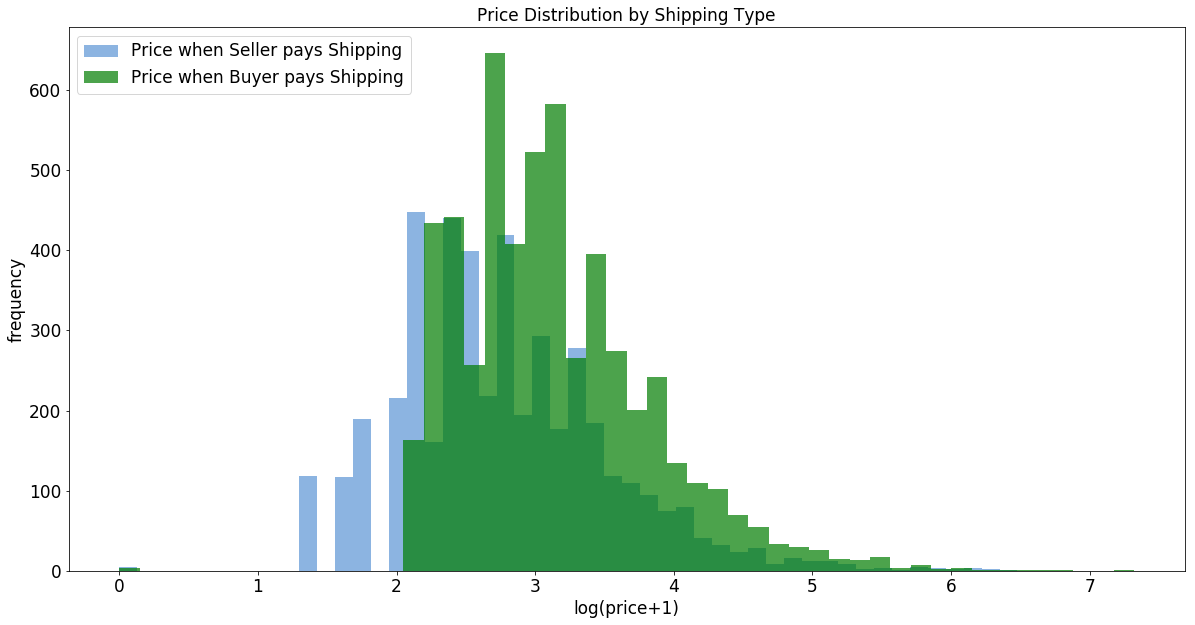

In [10]:
fig ,ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(prc_shipByseller+1),color='#8CB4E1',alpha=1.0,bins=50,
        label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer+1),color='#007D00',alpha=0.7,bins=50,
        label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison',ylabel='% of Dataset in Bin')
plt.xlabel('log(price+1)',fontsize=17)
plt.ylabel('frequency',fontsize=17)
plt.title('Price Distribution by Shipping Type',fontsize=17)
plt.tick_params(labelsize=17)
plt.legend(loc='upper left',fontsize=17)
plt.show()

In [11]:
print("There are {0} unique values in the category columns".format(train.category_name.nunique()))

There are 626 unique values in the category columns


In [12]:
#カテゴリー種類のTop 5
train.category_name.value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    396
Women/Tops & Blouses/T-Shirts                     294
Beauty/Makeup/Face                                271
Beauty/Makeup/Lips                                227
Beauty/Makeup/Eyes                                185
Name: category_name, dtype: int64

In [13]:
#missing categories（欠損値）
print('There are {0} items that do not have a label'.format(train.category_name.isnull().sum()))

There are 47 items that do not have a label


In [14]:
#category_nameを分割する
def split_cat(text):
    #欠損値があるのでtyr文を利用
    try: return text.split('/')
    except: return('No label','No label', 'No label')

In [15]:
#分割したカテゴリーを新しく特徴量として追加
#*は行列の転置
train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        NaN   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description  general_cat  \
0         1                                 No description yet          Men   
1         0  This keyboard is in great condition and works ...  Electronics   
2         1  Adorable top with a hint of lace and a key hol...        Women   
3         1  New with tags. Leather horses. Retail for [rm]...         Home   
4         0          Complete with certificate of authenticity        Women   

              subcat_1            subcat_2  
0                 Tops            T-shirts  
1  Computers & Tablets  Components & Parts  
2       Tops & Blouses              Blouse  
3           Home Décor  Home Décor Accents  
4              Jewelry           Necklaces

In [16]:
#repeat the same step for the test set
#検証データにも実施
test['general_cat'], test['subcat_1'], test['subcat_2'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))

In [17]:
#カテゴリーの大分類の種類の数
print('There are {0} unique first sub-categories'.format(train.subcat_1.nunique()))

There are 106 unique first sub-categories


In [18]:
#カテゴリーの中分類の種類の数
print('There are {0} unique second sub-categories'.format(train.subcat_2.nunique()))

There are 478 unique second sub-categories


In [19]:
#カテゴリーの一意のデータ取得
x = train.general_cat.value_counts().index.values.astype('str')
#対応するデータ数
y = train.general_cat.value_counts().values
#カテゴリ毎のデータ数比率の計算
pct = [('{:.2f}'.format(v*100))+'%' for v in (y/float(len(train)))]

In [30]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()
trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Number of Items by Main Category',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Category'))
fig=dict(data=[trace1], layout=layout)
plotly.offline.iplot(fig)

In [36]:
x = train['subcat_1'].value_counts().index.values.astype('str')[:15]
y = train['subcat_1'].value_counts().values[:15]
pct = [('%.2f'%(v*100))+'%'for v in (y/float(len(train)))][:15]

In [39]:
trace1 = go.Bar(x=x,y=y,text=pct,
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale=False
                ))
layout = dict(title='Number of Items by SubCategory(Top 15)',
              yaxis=dict(title='Count'),
              xaxis=dict(title='SubCategory'))
fig=dict(data=[trace1],layout=layout)
plotly.offline.iplot(fig)

In [20]:
data_box = pd.concat([np.log(train.price),train.general_cat],axis=1)

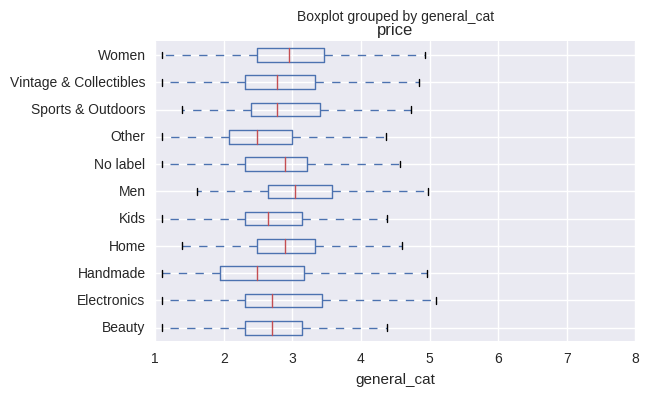

In [21]:
data_box.boxplot(column='price',by='general_cat',vert=False)

In [22]:
import re
import string
from sklearn.feature_extraction import stop_words

#記述に中に含まれる文字数をカウントする。ただし、ストップワードや数字は含まない。
def wordCount(text):
    try:        
        text = text.lower()
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        #regexに含まれる文字がtextにあった場合" "に変換する。
        txt = regex.sub(' ',text)
        #stopwordsに含まれず、かつ、3文字以上の場合
        words = [w for w in txt.split(' ') \
                if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except:
        return 0

stringには、文字列に関係した変数や関数が含まれている。主に、
- 特定のグループの文字列をまとめた変数
- 文字列をフォーマットする関数
の2つが入っている。

https://www.lifewithpython.com/2013/04/string.html

In [23]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [24]:
#re moduleで使えるようにエスケープする。
re.escape(string.punctuation)

'\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^\\_\\`\\{\\|\\}\\~'

In [25]:
train['desc_len'] = train['item_description'].apply(lambda x:wordCount(x))

In [26]:
test['desc_len'] = test['item_description'].apply(lambda x:wordCount(x))

In [27]:
train.head()

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        NaN   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description  general_cat  \
0         1                                 No description yet          Men   
1         0  This keyboard is in great condition and works ...  Electronics   
2         1  Adorable top with a hint of lace and a key hol...        Women   
3         1  New with tags. Leather horses. Retail for [rm]...         Home   
4         0          Complete with certificate of authenticity        Women   

              subcat_1            subcat_2  desc_len  
0                 Tops            T-shirts         1  
1  Computers & Tablets  Components & Parts        14  
2       Tops & Blouses              Blouse         8  
3           Home Décor  Home Décor Accents        14  
4              Jewelry           Necklaces         3

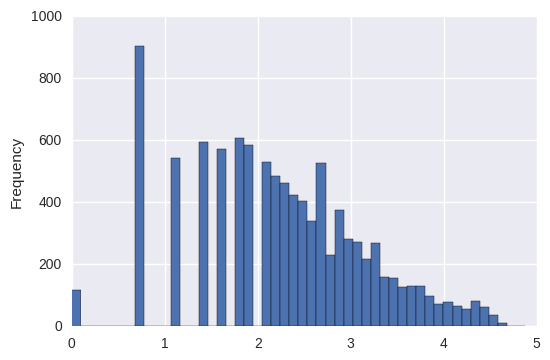

In [28]:
#文字数の分布
np.log(test.desc_len+1).plot(kind='hist',bins=50)

In [29]:
#文字数と価格の関係
df = train.groupby('desc_len')['price'].mean().reset_index()

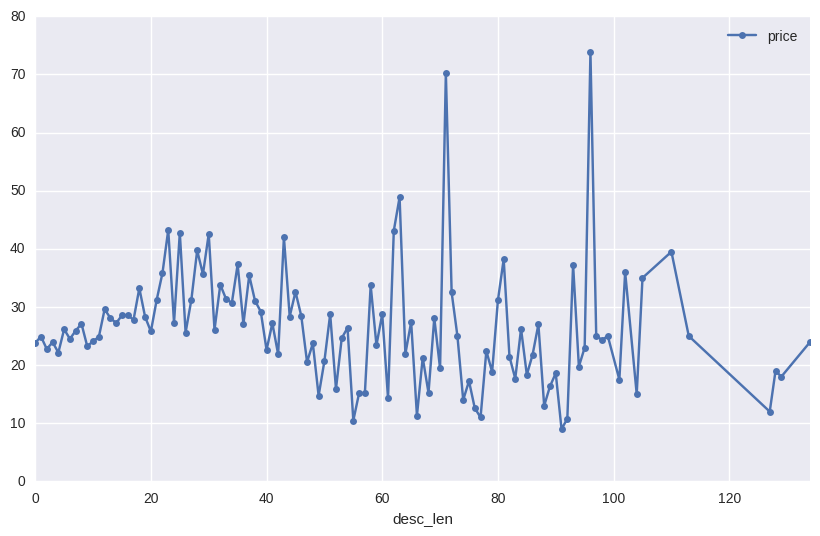

In [30]:
df.plot(kind='line',x='desc_len',y='price',figsize=(10,6),linestyle='-',marker='o',markersize=5)

In [31]:
#descriptionが欠損値の数
train.item_description.isnull().sum()

0

In [32]:
train = train[pd.notnull(train.item_description)]

In [33]:
import nltk
from nltk.corpus import stopwords

In [34]:
from nltk.tokenize import sent_tokenize, word_tokenize
stop = set(stopwords.words('english'))
def tokenize(text):
    
    try:
        regex = re.compile('[' +re.escape(string.punctuation)+'0-9\\r\\t\\n]')
        text = regex.sub(' ',text) #remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        #stopwordsに含まれないものだけ抽出
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
    
    except TypeError as e: print(test,e)

In [35]:
#apply the tokenizer into the item description column
train['tokens'] = train.item_description.map(tokenize)
test['tokens'] = test.item_description.map(tokenize)

In [36]:
for description, tokens in zip(train.item_description.head(),
                              train.tokens.head()):
    print('description:',description)
    print('tokens:',tokens)
    print()

('description:', 'No description yet')
('tokens:', ['description', 'yet'])
()
('description:', 'This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.')
('tokens:', ['keyboard', 'great', 'condition', 'works', 'like', 'came', 'box', 'ports', 'tested', 'work', 'perfectly', 'lights', 'customizable', 'via', 'razer', 'synapse', 'app'])
()
('description:', 'Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!')
('tokens:', ['adorable', 'top', 'hint', 'lace', 'key', 'hole', 'back', 'pale', 'pink', 'also', 'available', 'white'])
()
('description:', 'New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage')
('tokens:', ['new', 'tags', 'leather', 'horses', 'retail', 'stand', 'f

In [37]:
set(train.general_cat)

{'Beauty',
 'Electronics',
 'Handmade',
 'Home',
 'Kids',
 'Men',
 'No label',
 'Other',
 'Sports & Outdoors',
 'Vintage & Collectibles',
 'Women'}

In [38]:
from collections import Counter
#build dictionary with key=category and values as all the descriptions related
cat_desc = dict()
for cat in set(train.general_cat):
    text = ' '.join(train.loc[train.general_cat==cat,'item_description'].values)
    cat_desc [cat] = tokenize(text)
    
#find the most common words for the top 4 categories
women100 = Counter(cat_desc['Women']).most_common(100)
beauty100 = Counter(cat_desc['Beauty']).most_common(100)
kids100 = Counter(cat_desc['Kids']).most_common(100)
electronics100 = Counter(cat_desc['Electronics']).most_common(100)

In [39]:
from wordcloud import WordCloud

In [40]:
def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          max_words=50,max_font_size=40,
                          random_state=42
                         ).generate(str(tup))
    return wordcloud

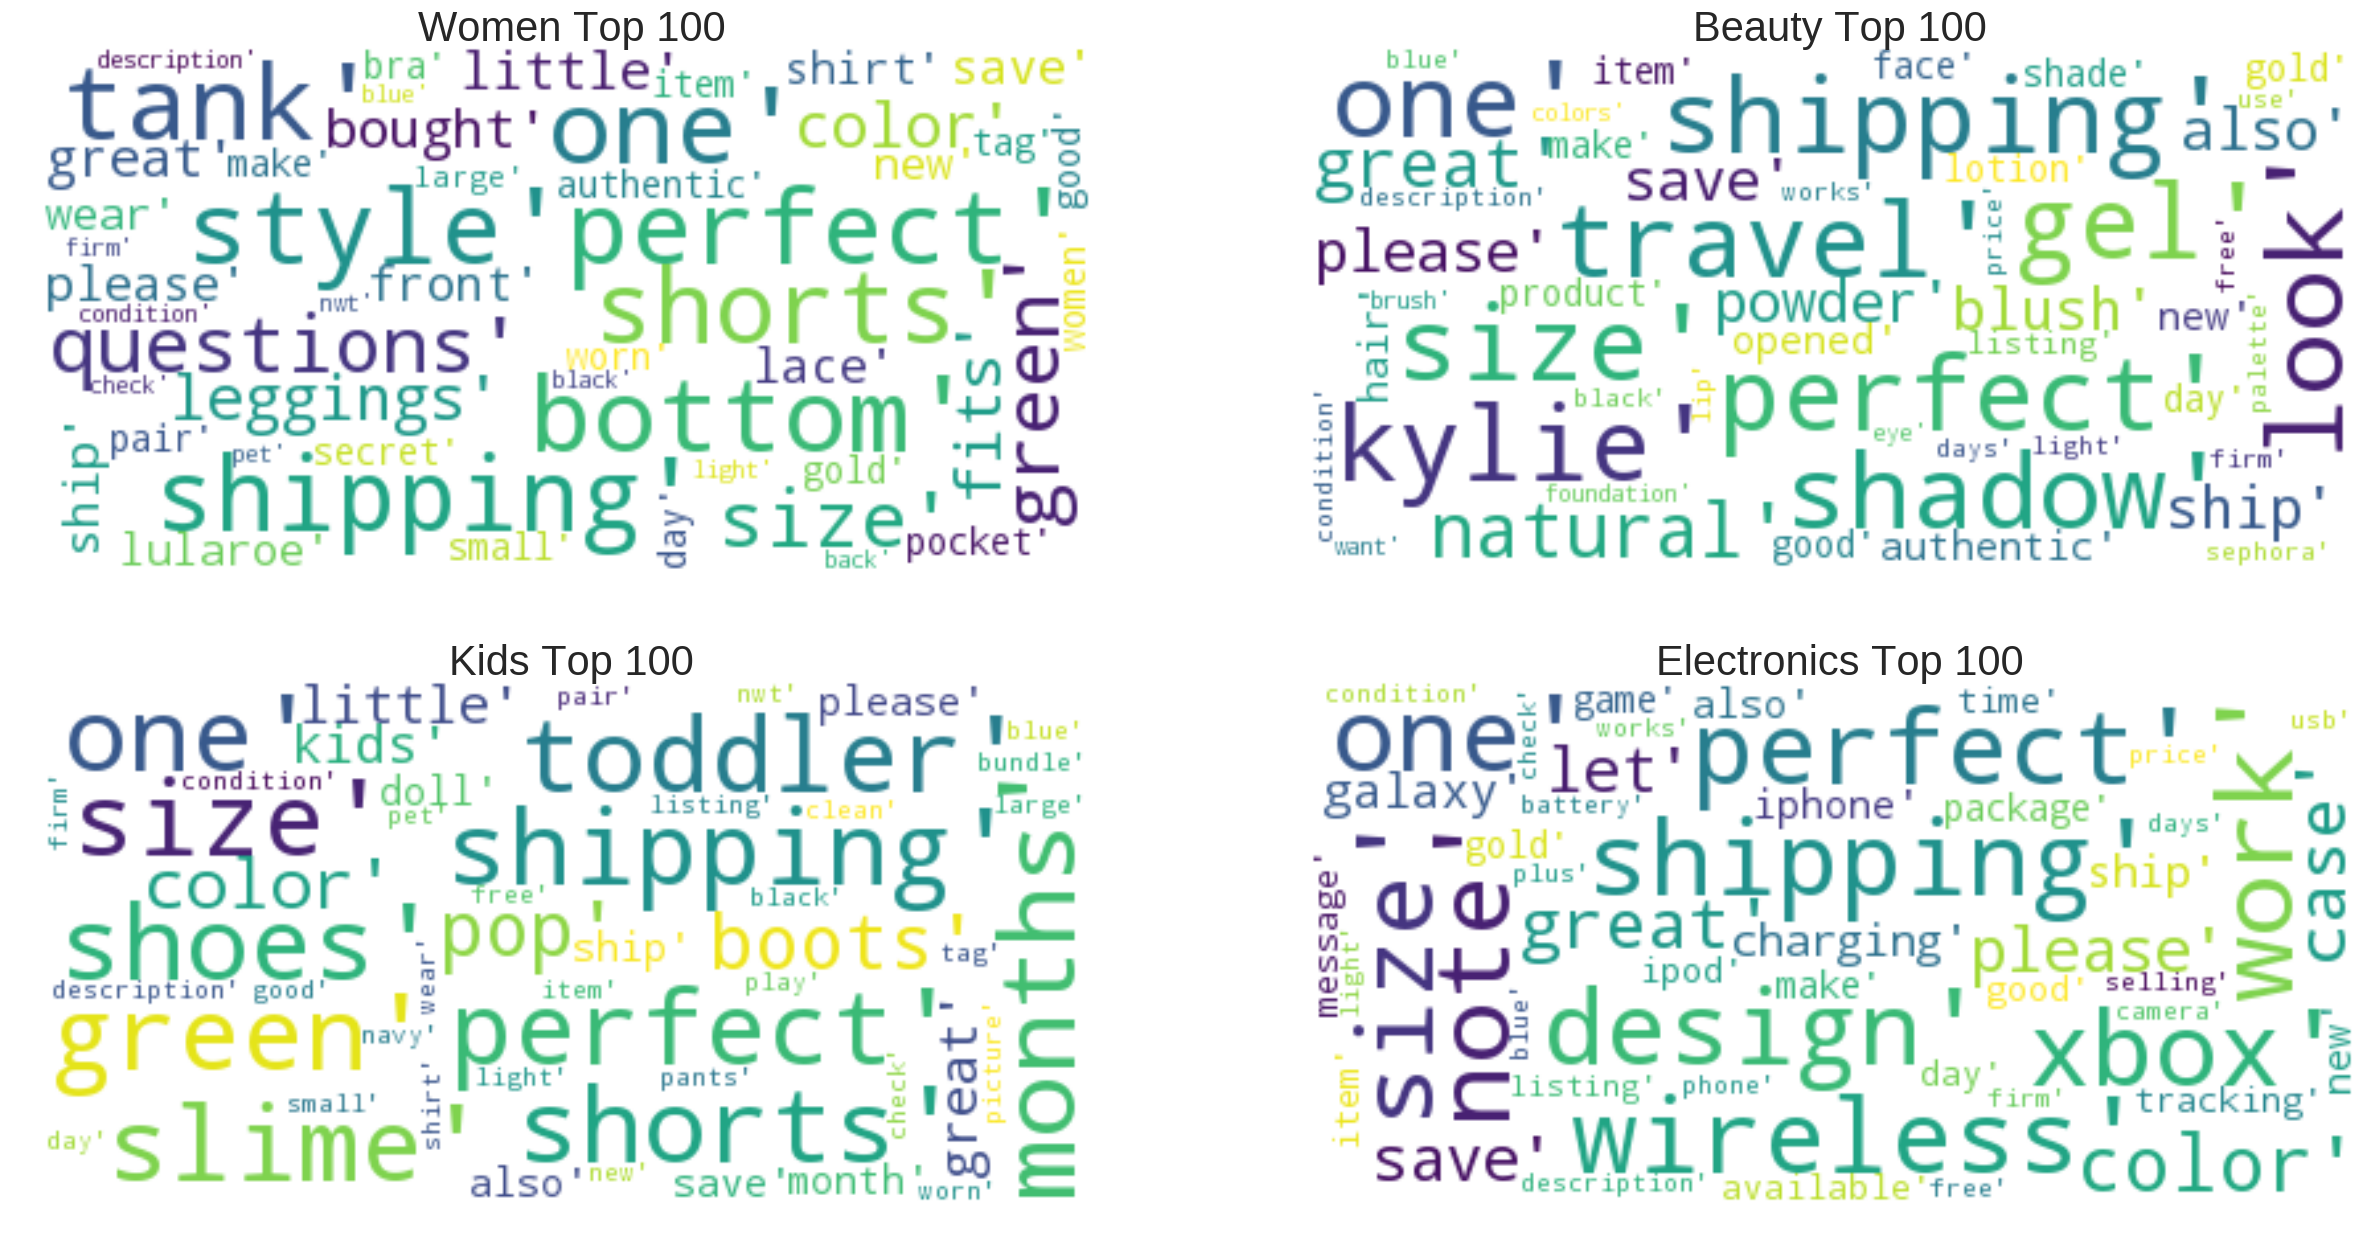

In [41]:
fig, axes = plt.subplots(2,2,figsize=(30,15))

ax = axes[0,0]
ax.imshow(generate_wordcloud(women100),interpolation='bilinear')
ax.axis('off')
ax.set_title('Women Top 100',fontsize=30)

ax = axes[0,1]
ax.imshow(generate_wordcloud(beauty100))
ax.axis('off')
ax.set_title('Beauty Top 100',fontsize=30)

ax = axes[1,0]
ax.imshow(generate_wordcloud(kids100))
ax.axis('off')
ax.set_title('Kids Top 100',fontsize=30)

ax = axes[1,1]
ax.imshow(generate_wordcloud(electronics100))
ax.axis('off')
ax.set_title('Electronics Top 100',fontsize=30)

## Pre-processing:tf-idf

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,
                             max_features=1000,
                             tokenizer=tokenize,
                             ngram_range=(1,2))

In [43]:
all_desc = np.append(train.item_description.values,test.item_description.values)
vz = vectorizer.fit_transform(list(all_desc))

In [44]:
# create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(),vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf),orient='index')
tfidf.columns = ['tfidf']

In [45]:
tfidf.sort_values(by='tfidf',ascending=True).head(10)

tfidf
new        2.164321
size       2.332614
brand      2.736753
condition  2.825470
brand new  2.844894
free       2.916693
shipping   3.065589
worn       3.132892
used       3.150343
never      3.275020

In [46]:
tfidf.sort_values(by='tfidf',ascending=False).head(10)

tfidf
henna      8.013166
teeth      7.536242
note note  7.348189
wax        7.239976
mailers    7.165868
labels     7.142337
brow       7.119348
tempered   7.119348
yeti       7.119348
soap       7.032337

In [47]:
trn = train.copy()
tst = test.copy()
trn['is_train'] = 1
tst['is_train'] = 0

sample_sz = 1500

combined_df = pd.concat([trn,tst])
combined_sample = combined_df.sample(n=sample_sz)
vz_sample = vectorizer.fit_transform(list(combined_sample['item_description']))

In [48]:
from sklearn.decomposition import TruncatedSVD

n_comp = 30
svd = TruncatedSVD(n_components=n_comp,random_state=42)
svd_tfidf = svd.fit_transform(vz_sample)

In [49]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2,verbose=1,random_state=42,n_iter=1500)

In [50]:
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.000000
[t-SNE] Error after 100 iterations with early exaggeration: 0.790981
[t-SNE] Error after 325 iterations: 0.690029


In [51]:
tsne_tfidf.shape

(1500, 2)

In [52]:
combined_sample.reset_index(inplace=True,drop=True)

In [53]:
tfidf_df = pd.DataFrame(tsne_tfidf,columns=['x','y'])
tfidf_df['description'] = combined_sample.item_description
tfidf_df['tokens'] = combined_sample.tokens
tfidf_df['category'] = combined_sample.general_cat

In [54]:
tfidf_df.plot(x='x',y='y',kind='scatter')

## K-Means Clustering

In [55]:
from sklearn.cluster import MiniBatchKMeans
num_clusters = 30
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters,
                               init='k-means++',
                               n_init=1,
                               init_size=1000,batch_size=1000,verbose=0,max_iter=1000)

In [56]:
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

/home/kyohei/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1279: DeprecationWarning: This function is deprecated. Please call randint(0, 19999 + 1) instead
  0, n_samples - 1, init_size)
/home/kyohei/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:630: DeprecationWarning: This function is deprecated. Please call randint(0, 19999 + 1) instead
  0, n_samples - 1, init_size)
/home/kyohei/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1328: DeprecationWarning: This function is deprecated. Please call randint(0, 19999 + 1) instead
  0, n_samples - 1, self.batch_size)
/home/kyohei/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1328: DeprecationWarning: This function is deprecated. Please call randint(0, 19999 + 1) instead
  0, n_samples - 1, self.batch_size)
/home/kyohei/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1328: DeprecationWarning: This function is deprecated. Please call randint(0, 1999

In [57]:
#repeat the same steps for the sample
kmeans = kmeans_model.fit(vz_sample)
kmeans_clusters = kmeans.predict(vz_sample)
kmeans_distances = kmeans.transform(vz_sample)
#reduce dimension to 2 using tsne
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

/home/kyohei/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1279: DeprecationWarning: This function is deprecated. Please call randint(0, 1499 + 1) instead
  0, n_samples - 1, init_size)
/home/kyohei/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:630: DeprecationWarning: This function is deprecated. Please call randint(0, 1499 + 1) instead
  0, n_samples - 1, init_size)
/home/kyohei/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1328: DeprecationWarning: This function is deprecated. Please call randint(0, 1499 + 1) instead
  0, n_samples - 1, self.batch_size)
/home/kyohei/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1328: DeprecationWarning: This function is deprecated. Please call randint(0, 1499 + 1) instead
  0, n_samples - 1, self.batch_size)
/home/kyohei/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1328: DeprecationWarning: This function is deprecated. Please call randint(0, 1499 + 1

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.000000
[t-SNE] Error after 100 iterations with early exaggeration: 0.853411
[t-SNE] Error after 300 iterations: 0.735198


In [62]:
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x','y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['description'] = combined_sample['item_description']
kmeans_df['category'] = combined_sample['general_cat']

In [65]:
kmeans_df.cluster.value_counts()

11    795
19    104
7      99
8      64
6      51
18     50
22     44
4      43
25     41
9      40
17     37
20     34
24     21
28     19
16     17
14     14
10     12
29      2
23      2
12      1
13      1
15      1
21      1
26      1
5       1
27      1
3       1
2       1
1       1
0       1
Name: cluster, dtype: int64

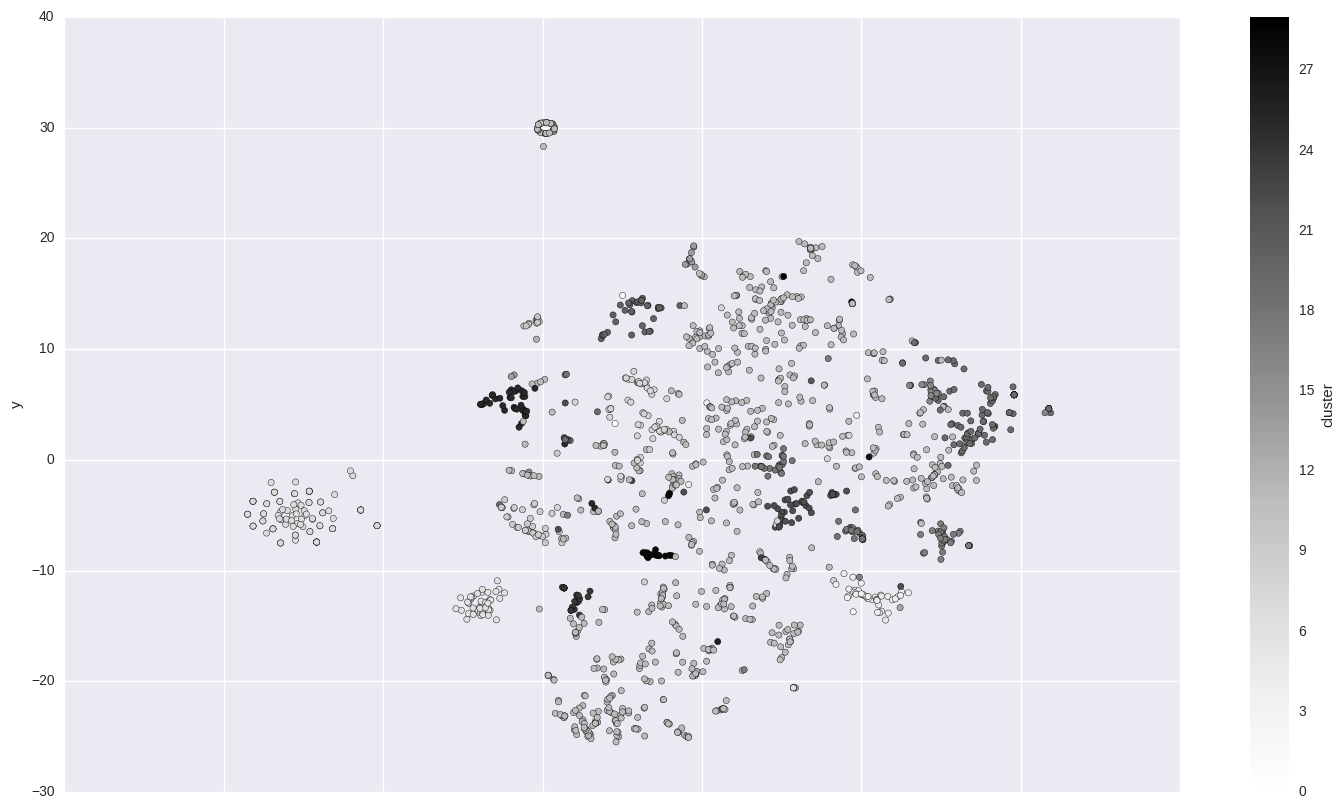

In [73]:
kmeans_df.plot(kind='scatter',x='x',y='y',c='cluster',figsize=(18,10))

## Latent Dirichlet Allocation

https://medium.com/intuitionmachine/the-two-paths-from-natural-language-processing-to-artificial-intelligence-d5384ddbfc18

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
cvectorizer = CountVectorizer(min_df=4,
                              max_features=1000,
                              tokenizer=tokenize,
                              ngram_range=(1,2))

In [75]:
cvz = cvectorizer.fit_transform(combined_sample['item_description'])

In [81]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_topics=20,
                                      learning_method='online',
                                      max_iter=20,
                                      random_state=42)

In [82]:
X_topics = lda_model.fit_transform(cvz)